In [1]:
import os
import pandas as pd

from rdkit import Chem
from rdkit.Chem import Draw, AllChem

In [61]:
def extract_sdf_fields(sdf_file_path, fields = ['_Name', 'minimizedAffinity', 'CNNscore', 'CNNaffinity', 'CNN_VS', 'CNNaffinity_variance'], mode=9):
    """
    Extract specific fields from SDF file into a pandas DataFrame
    
    Args:
        sdf_file_path (str): Path to input SDF file
        fields (list): List of fields to extract
        mode (int): For output from gnina, mode is the number of poses per ligand
    """
    all_structures = Chem.SDMolSupplier(sdf_file_path)

    res = []

    for mol in all_structures:
        data = {}
        for field in fields:
            data[field] = mol.GetProp(field)
        res.append(data)

    df = pd.DataFrame(res)
    df.rename(columns={'_Name': 'Name'}, inplace=True)

    # add names
    if any(df["Name"]==""):
        df["Name"] = df.index // mode
    
    df["mode"] = df.index % mode

    return df

In [3]:
def prepare_mol_for_display(mol_3d, removeHs=True):
    """
    Convert a 3D molecule to a 2D representation for better display
    
    Parameters:
    mol_3d (rdkit.Chem.rdchem.Mol): Input 3D molecule
    removeHs (bool): Whether to remove hydrogens
    
    Returns:
    rdkit.Chem.rdchem.Mol: Molecule ready for 2D display
    """
    # Make a copy to avoid modifying the input
    mol = Chem.Mol(mol_3d)

    if removeHs:
        mol = Chem.RemoveHs(mol)

    # Generate 2D coordinates
    AllChem.Compute2DCoords(mol)
    
    return mol

In [4]:
def split_sdf(sdf_file_path, n=100):
    """
    Split an SDF file into multiple files, each containing n molecules
    
    Parameters:
    sdf_file_path (str): Path to input SDF file
    n (int): Number of molecules per output file
    """
    all_structures = Chem.SDMolSupplier(sdf_file_path)
    out_folder = sdf_file_path.rsplit(".", 1)[0]
    os.makedirs(out_folder, exist_ok=True)

    i = 0
    for mol in all_structures:
        if i % n == 0:
            writer = Chem.SDWriter(f"{out_folder}/ligands_{i//n}.sdf")
        writer.write(mol)
        i += 1

In [36]:
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    ''' mylist.sort(key=natural_keys) sorts in human order'''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [39]:
def merge_sdf(sdf_folder, output_path, sorted=False):
    """
    Merge multiple SDF files into a single file
    If sorted, uses the natural order (ie with 1<2<10) to sort the files before merging 
    """
    writer = Chem.SDWriter(output_path)
    files = os.listdir(sdf_folder)
    if sorted:
        files.sort(key=natural_keys)
    for file in files:
        if file.endswith(".sdf"):
            reader = Chem.SDMolSupplier(f"{sdf_folder}/{file}")
            for mol in reader:
                writer.write(mol)
    writer.close()

## Get result from gnina

In [127]:
ref = "gnina_outputs/1uak_SAM.sdf"
df_ref = extract_sdf_fields(ref)
df_ref["Name"] = "SAM"

mode=9
input = "gnina_outputs/gen_ligand_4YVG_mode9.sdf"
mode=1
input = "gnina_outputs/generated_ligands/5428_1_4YVG_SAM_merged.sdf"
df = extract_sdf_fields(input, mode=mode)
df = pd.concat([df_ref, df], ignore_index=True)

df = df.astype({'minimizedAffinity': 'float', 'CNNscore': 'float', 'CNNaffinity': 'float', 'CNN_VS': 'float', 'CNNaffinity_variance': 'float'})

[12:32:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[12:32:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[12:32:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[12:32:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[12:32:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[12:32:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[12:32:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[12:32:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[12:32:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

In [137]:
score = "minimizedAffinity"
score = "CNNaffinity"

df_CNN = df.sort_values(by=score, ascending=(score=="minimizedAffinity")).reset_index(drop=True)
df_CNN

,Name,minimizedAffinity,CNNscore,CNNaffinity,CNN_VS,CNNaffinity_variance,mode
0,4239,-9.74282,0.973764,8.968769,8.733467,0.035068,0
1,1926,-10.71392,0.959654,8.500175,8.157231,0.146821,0
2,2922,-8.87604,0.981506,8.480239,8.323407,0.320862,0
3,5003,-9.50508,0.910901,8.382032,7.635201,0.067859,0
4,2268,-9.20815,0.934063,8.271130,7.725757,0.127049,0
...,...,...,...,...,...,...,...
5104,3749,-4.08592,0.824687,2.812388,2.319339,0.642610,0
5105,1746,-5.22630,0.897312,2.799639,2.512150,1.145721,0
5106,93,-3.82654,0.603196,2.766964,1.669021,0.527485,0
5107,3755,-3.60683,0.803936,2.764476,2.222461,0.699435,0


In [138]:
score = "minimizedAffinity"
# score = "CNNaffinity"

df_mini = df.sort_values(by=score, ascending=(score=="minimizedAffinity")).reset_index(drop=True)
df_mini

,Name,minimizedAffinity,CNNscore,CNNaffinity,CNN_VS,CNNaffinity_variance,mode
0,4571,-14.70036,0.214853,6.193882,1.330773,0.935993,0
1,2195,-14.09547,0.881127,7.014802,6.180929,0.080762,0
2,524,-14.03790,0.976477,7.110284,6.943030,0.055692,0
3,4416,-13.03975,0.979503,7.997013,7.833102,0.148397,0
4,4581,-13.03624,0.954377,8.037666,7.670963,0.135060,0
...,...,...,...,...,...,...,...
5104,4011,8.88405,0.602359,6.219526,3.746387,0.157969,0
5105,1004,12.31308,0.730564,4.543913,3.319618,0.061951,0
5106,3131,14.91739,0.438808,6.696758,2.938589,0.078408,0
5107,2753,20.98111,0.326357,6.436661,2.100648,0.106809,0


### Draw best scoring molecule

total nb of structures: 5100
best id: 4239


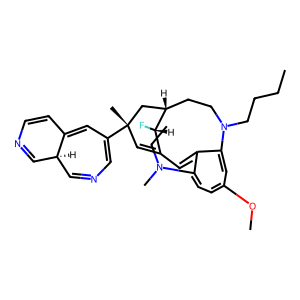

In [139]:
all_structures = Chem.SDMolSupplier(input)
print("total nb of structures:", len(all_structures))

id_best = int(mode*df_CNN.iloc[0]["Name"]+df_CNN.iloc[0]["mode"])
print("best id:", id_best)
best_mol = all_structures[id_best]
Draw.MolToImage(best_mol)

best_mol_2d = prepare_mol_for_display(best_mol)
Draw.MolToImage(best_mol_2d)

best id: 4571


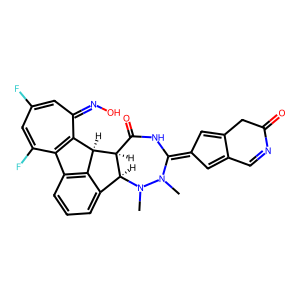

In [140]:
id_best = int(mode*df_mini.iloc[0]["Name"]+df_mini.iloc[0]["mode"])
print("best id:", id_best)
best_mol = all_structures[id_best]
Draw.MolToImage(best_mol)

best_mol_2d = prepare_mol_for_display(best_mol)
Draw.MolToImage(best_mol_2d)